In [6]:
# Data libraries
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
import scipy.io.wavfile as sci_wav  # Open wav files
import os  # Manipulate files
import warnings  # Warning removal
warnings.filterwarnings('ignore')

# List the wav files
ROOT_DIR = '../input/cats_dogs/cats_dogs/'
X_path = os.listdir(ROOT_DIR)
y = [0 if 'cat' in f else 1 for f in X_path]  # change y to int values

# Split train and test
X_train, X_test, y_train, y_test = train_test_split(X_path, y, test_size=0.33)

print("in X, there is {} cats and {} dogs".format(len(y) - sum(y), sum(y)))
print("in X_train, there is {} cats and {} dogs".format(len(y_train) - sum(y_train), sum(y_train)))
print("in X_test, there is {} cats and {} dogs".format(len(y_test) - sum(y_test), sum(y_test)))

in X, there is 164 cats and 113 dogs
in X_train, there is 116 cats and 69 dogs
in X_test, there is 48 cats and 44 dogs


In [7]:
def read_wav_files(wav_files):
    '''Returns a list of audio waves
    Params:
        wav_files: List of .wav paths
    
    Returns:
        List of audio signals
    '''
    if not isinstance(wav_files, list):
        wav_files = [wav_files]
    return [sci_wav.read(ROOT_DIR + f)[1] for f in wav_files]

print(read_wav_files('cat_1.wav'))
print(read_wav_files(['cat_1.wav', 'cat_2.wav']))

X_train, X_test = map(read_wav_files, [X_train, X_test])

[array([ 124,  107,    7, ..., -545, -494, -529], dtype=int16)]
[array([ 124,  107,    7, ..., -545, -494, -529], dtype=int16), array([-1028, -1039, -1064, ...,     6,    38,     2], dtype=int16)]


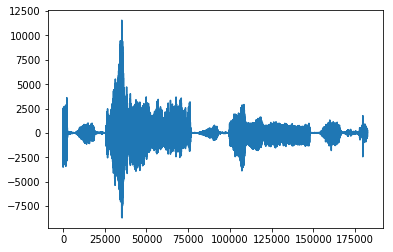

In [17]:
import matplotlib.pyplot as plt
plt.figure()
plt.plot(X_train[0])
plt.show()

In [8]:
X_all = read_wav_files(X_path)
X_all_cat = [_x for _x, _y in zip(X_all, y) if _y == 0]
X_all_dog = [_x for _x, _y in zip(X_all, y) if _y == 1]
X_all_cat = np.concatenate(X_all_cat)
X_all_dog = np.concatenate(X_all_dog)

print('Overall, there is {:.2f}sec of cats and {:.2f}sec of dogs'.format(
    len(X_all_cat) / 16000, len(X_all_dog) / 16000))

Overall, there is 1323.90sec of cats and 598.44sec of dogs


In [21]:
import pandas as pd
import random

# Randomize cat and dog file paths
cat_paths = [_x for _x, _y in zip(X_path, y) if _y == 0]
dog_paths = [_x for _x, _y in zip(X_path, y) if _y == 1]
random.shuffle(cat_paths)
random.shuffle(dog_paths)

n = int(len(cat_paths) * .3)

splits = {
    'train_cat': cat_paths[n:],
    'train_dog': dog_paths[n:],
    'test_cat': cat_paths[:n],
    'test_dog': dog_paths[:n]
}
df = pd.DataFrame(dict([ (k,pd.Series(v)) for k,v in splits.items() ]))
df.to_csv('train_test_split.csv')

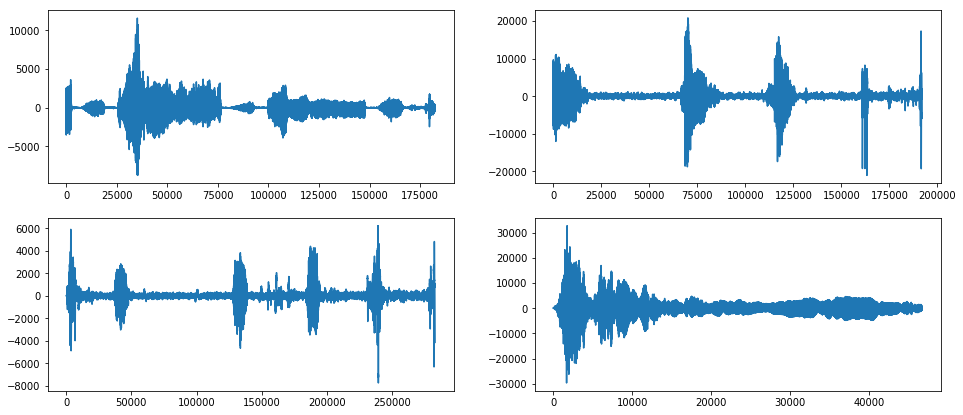

In [29]:
import matplotlib.pyplot as plt

fig, axs = plt.subplots(2, 2, figsize=(16,7))
axs[0][0].plot(X_train[0])
axs[0][1].plot(X_train[1])
axs[1][0].plot(X_train[2])
axs[1][1].plot(X_train[3])
plt.show()

In [55]:
def cats_and_dogs_gen(dataset='train', n_samples=20, sample_len=16000):
    '''This generator is going to return batchs of size <n_sample>*<sample_len>
    
    Params:
        dataset: Either 'train' or 'test', to choose in between them
        n_samples: amount of samples per batch
        sample_len: size of the samples in a batch
    '''
    # Select between train or test
    X, y = (X_train, y_train) if dataset is 'train' else (X_test, y_test)
    
    # Create two huuuges 1D arrays with all the audio waves concatenated one after the other
    # (one for the cats, the other for the dogs)
    X_cat = np.concatenate([_x for _x, _y in zip(X, y) if _y == 0])
    X_dog = np.concatenate([_x for _x, _y in zip(X, y) if _y == 1])
    
    # Apply normalization and mean suppression
    X_cat = preprocessing.scale(X_cat)
    X_dog = preprocessing.scale(X_dog)
    
    for _ in range(int(max(sum(y), len(y) - sum(y)) / n_samples)):
        y_batch = np.zeros(n_samples)
        X_batch = np.zeros((n_samples, sample_len))
        for idx in range(n_samples):
            y_batch[idx] = idx % 2
            _X = X_cat if y_batch[idx] == 0 else X_dog
            x_idx = np.random.randint(len(_X) - sample_len)
            X_batch[idx] = _X[x_idx : x_idx + sample_len]
        
        yield (X_batch.reshape(n_samples, sample_len, 1),
               y_batch.reshape(-1, 1) )
        
# Test the generator here
x, y = next(cats_and_dogs_gen('train'))
print(x.shape, y.shape)

(20, 16000, 1) (20, 1)


In [63]:
gen = cats_and_dogs_gen('train')
for _ in range(5):
    print(len(next(gen)[0][0]))

16000
16000
16000
16000
16000
